In [1]:
## Importing packages that will be used ##
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
### Parsing the Hurdat2 Dataset ###
storms = []
with open('Data/hurdat2_8_28_25.csv') as hurdat2:
    info = hurdat2.readlines()
i = 0
while i < len(info):
    line = info[i].strip().split(',')
    storm_id = line[0].strip()
    storm_name = line[1].strip()
    track_entries = int(line[2].strip())
    year = storm_id[-4:]

    tracks = [info[j].strip().split(',') for j in range(i+1, i+1+track_entries)]
    df = pd.DataFrame(tracks, columns = ["date", "time", "ID", "Cylcone Type", "Lat", "lon",
                                              "Max Winds", "Min Pressure", "34kt NEQ", "34kt SEQ", 
                                              "34kt SWQ", "34kt NWQ", "50kt NEQ", "50kt SEQ", "50kt SWQ",
                                              "50kt NWQ", "64kt NEQ", "64kt SEQ","64kt SWQ", "64kt NWQ", 
                                              "Radius of Max Winds"])
    df["storm_id"] = storm_id
    df["storm_name"] = storm_name
    df["year"] = year

    if any(id.strip() == "L" for id in df["ID"].values):
        storms.append(df)
    i += track_entries + 1
       
Landfalling_storms = pd.concat(storms, ignore_index = True)



In [22]:
### Altering the Dataframe ###
Landfalling_storms['date'] = pd.to_datetime(Landfalling_storms['date'], dayfirst = "True",)
Landfall_only = Landfalling_storms[Landfalling_storms["ID"].str.strip() == "L"] # Showing only the landfalls for each storm
Landfall_only = Landfall_only.set_index(['storm_name', 'date', 'storm_id']) ## Setting a multi-index with storm name and year
Landfall_only = Landfall_only.drop(columns = ['ID']) # Dropping ID and Storm_id cause they are no longer needed

### Converting Maximum winds in pandas dataset into Category of Storm ###
Landfall_only["Max Winds"] = pd.to_numeric(Landfall_only["Max Winds"].values)
#Landfall_only["Max Winds"] = Landfall_only["Max Winds"] * 1.15078 # ----> We do no need to convert to mph, however if needed uncomment this line and change the conditions below for MPH rather than knots
Landfall_only["category"] = np.select([
    Landfall_only["Max Winds"] <= 33, #38 mph 
    Landfall_only["Max Winds"] < 64, #73 mph
    Landfall_only["Max Winds"] < 82, #95 mph
    Landfall_only["Max Winds"] < 95, #110 mph
    Landfall_only["Max Winds"] < 113, #129 mph
    Landfall_only["Max Winds"] < 137, #156 mph
    Landfall_only["Max Winds"] >= 137, #157+ mph
], 
[
    "TD",
    "TS",
    "Cat 1",
    "Cat 2",
    "Cat 3",
    "Cat 4",
    "Cat 5"
],
default = 'Unknown')


In [32]:
## Assigning States to each Landfall ##
Landfall_only = Landfall_only.reset_index() #Resetting index to make storm_name and year columns again
#Converting lat and longitude values to purely numeric numbers
Landfall_only['lat_num'] = Landfall_only['Lat'].str.strip('N').astype(float)
Landfall_only['lon_num'] = Landfall_only['lon'].str.strip('W').astype(float) * -1

def assign_coast(lon,lat):
    if lon >= -98 and lon <= -80 and lat >= 24 and lat <= 31:
        return "Gulf Coast"
    #if lon >= -97.6 and lon <=-93.5 and lat >= 25.8 and lat <= 30.2:
        #return "Texas"
    #elif lon >= -93.7 and lon <= -89 and lat >= 28.9 and lat <= 30.3:
        #return "Louisiana"
    # add other states as needed 
    return
Landfall_only['Coast Line'] = Landfall_only.apply(lambda row: assign_coast(row['lon_num'], row['lat_num']), axis=1)



In [47]:
### Saving to Excel ###
Landfall_only.to_excel("Landfalling_Storms_1851_2024.xlsx", engine = 'openpyxl')

Text(0.5, 1.0, 'Landfalling Atlantic Tropical Cyclones (1851-2024)')

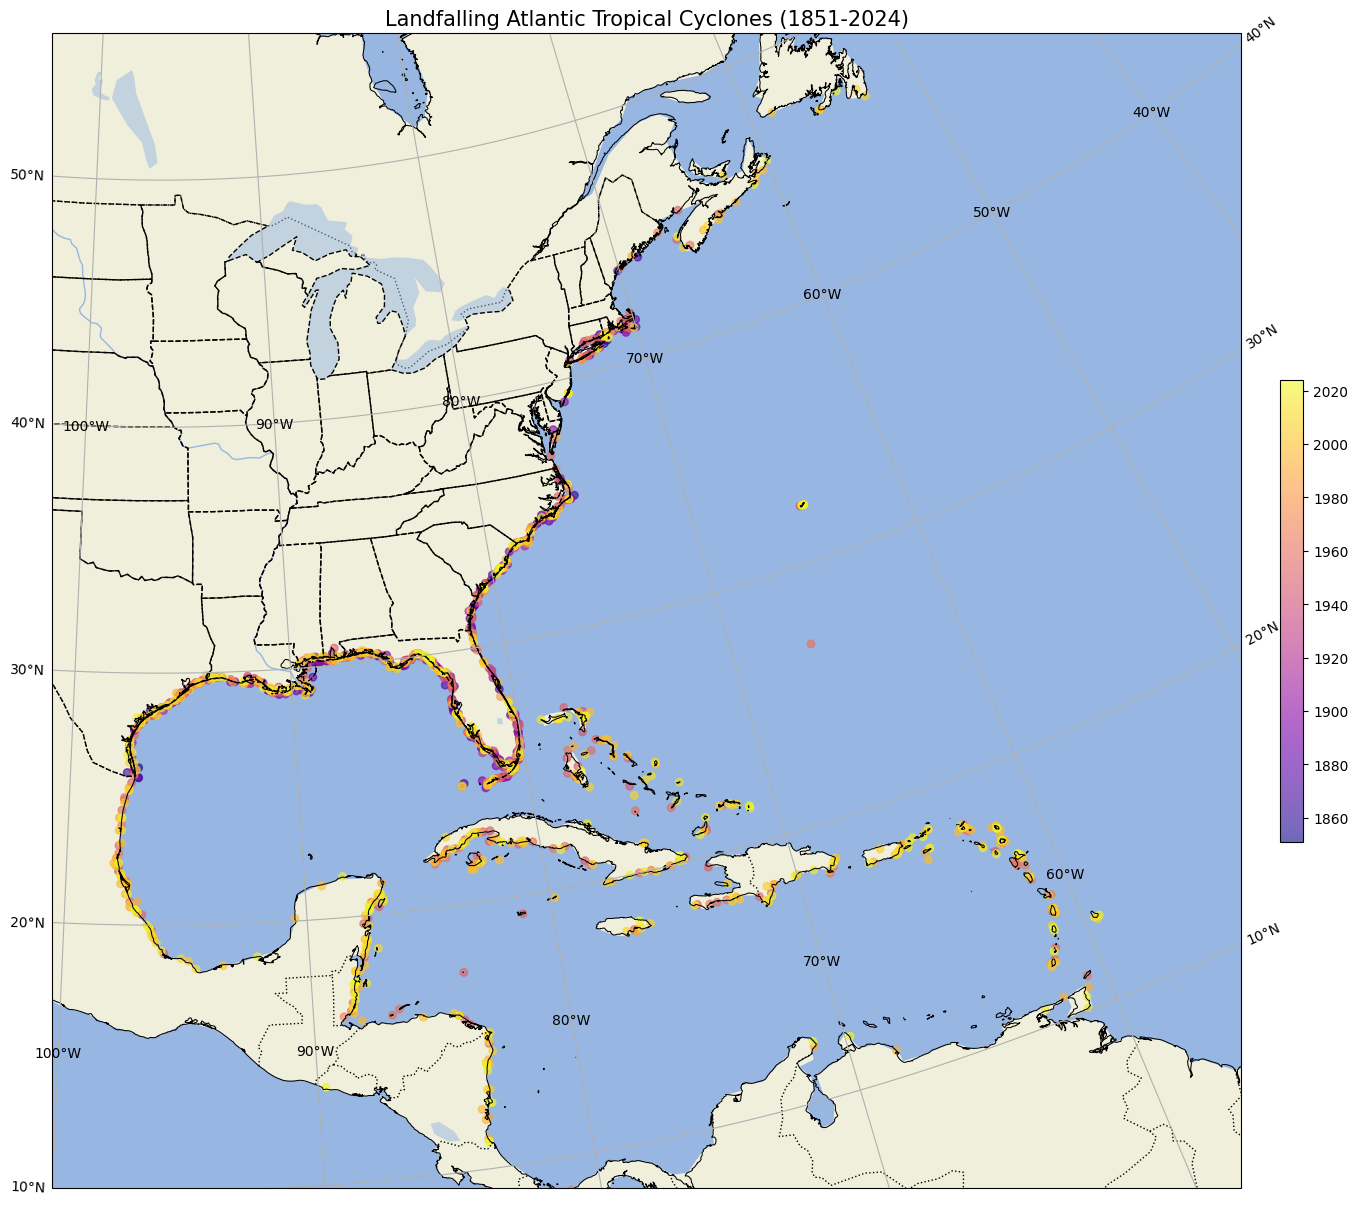

In [26]:
### Plotting the Landfalling Storms ###
fig, ax = plt.subplots(figsize= (25,15), subplot_kw = {'projection':ccrs.LambertConformal()})
## Defining Lat and Lon ##
Lat = Landfall_only['Lat'].str.strip('N').astype(float)
Lon = Landfall_only['lon'].str.strip('W').astype(float) * -1
## Converting Years to numeric values for color mapping ##
Landfall_only['year'] = pd.to_numeric(Landfall_only['year'].values)
Landfall_only['category'] = pd.to_numeric(Landfall_only['category'].values, errors = 'coerce')
## Making the Map##
ax.set_extent([-100, -55, 10, 50], crs=ccrs.PlateCarree())
map_data = ax.scatter(Lon, Lat,  c = Landfall_only['year'], 
                      cmap = 'plasma', s= 30, alpha = 0.6, 
                      transform=ccrs.PlateCarree())
cbar = plt.colorbar(map_data, ax=ax, shrink = 0.4, orientation = 'vertical', pad = 0.02)
## Adding features ##
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.coastlines(resolution = '10m', linewidth = 0.75) # Added very high res coastlines to see small islands
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels = True)
ax.add_feature(cfeature.STATES, linestyle = '--')
## Adding Title ##
plt.title('Landfalling Atlantic Tropical Cyclones (1851-2024)', fontsize = 15)


poly1d([ 3.22218742e-03, -3.74298813e+00])

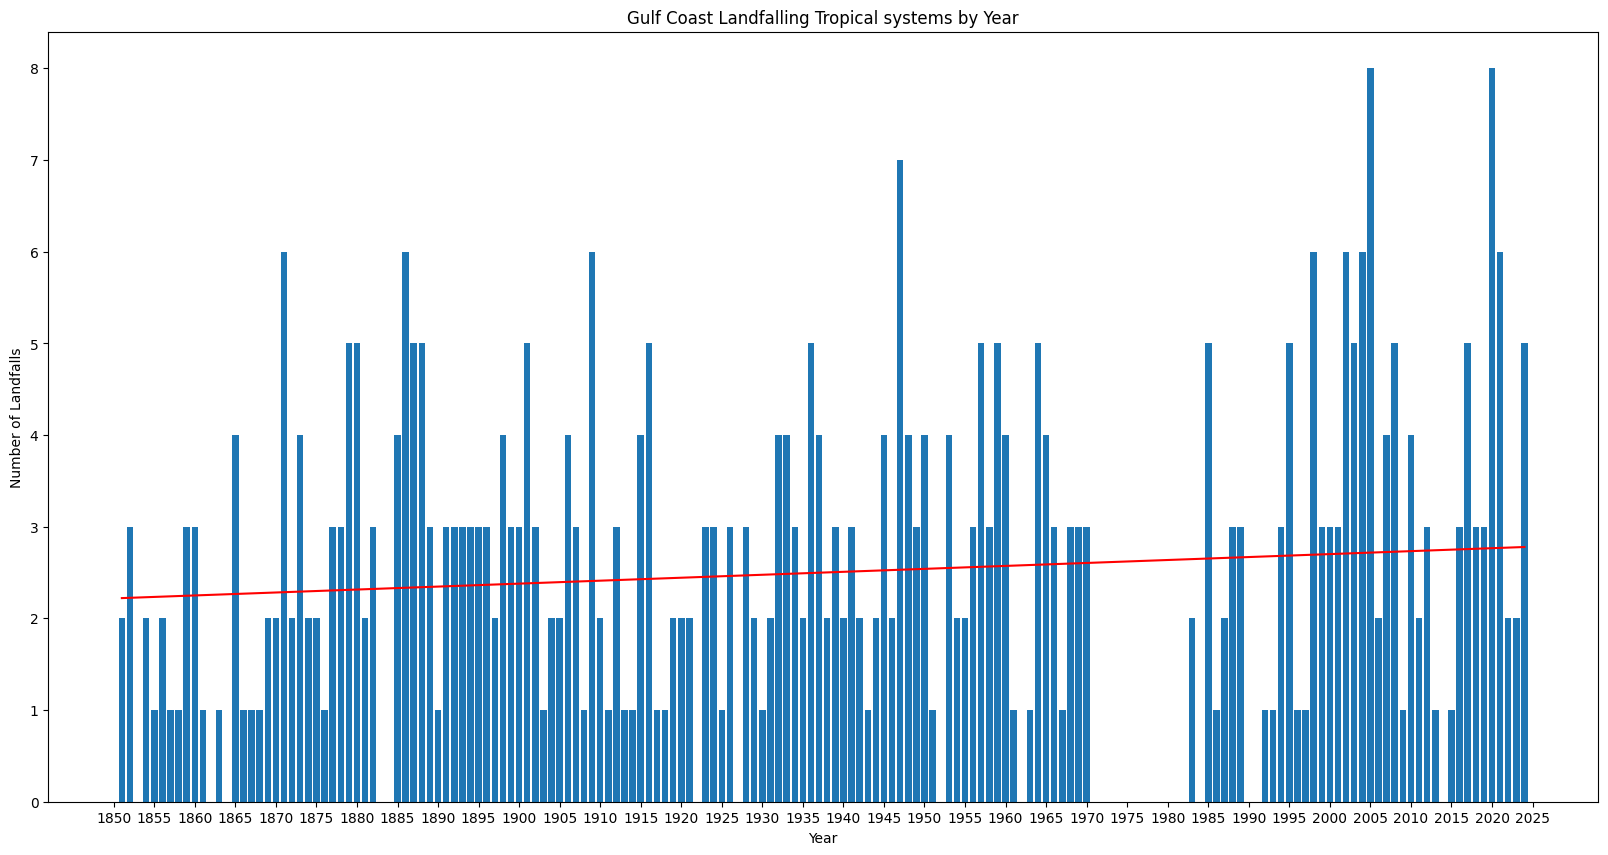

In [ ]:
## Create a new figure of the frequency of landfalls for various landfalling locations ##
# 1st: Landfalling frequency by locations by state, (Start with texas) - make a scatterplot with x and y axis showing frequency of landfalls by year
# x axis = year, y axis = frequency of landfalls
# also make a trend graph for multiple landfalling per storms

## Shift focus to the whole coasts
#      - Split the atlantic into multiple coastlines 

# Gulf coast is completed:
# Lets try and make a function that can do this for all states
coasts = ["Gulf Coast"] # add other coastlines as needed
def plot_landfall_frequency(coasts):
    for coast in coasts:
        state_data = Landfall_only[Landfall_only['Coast Line'] == coast]
        state_data_altered = state_data.drop_duplicates(subset=['storm_id','year','Coast Line'])
        all_years = np.arange(Landfall_only['year'].min(), Landfall_only['year'].max()+1)
        frequency = state_data_altered.groupby('year').size().reindex(all_years, fill_value=0)
        ## Plotting the frequency ##
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.bar(frequency.index, frequency)
        ax.set_title(f'{coast} Landfalling Tropical systems by Year')
        ax.set_xlabel("Year")
        ax.set_ylabel("Number of Landfalls")
        x_range = np.arange(1850, 2026, 5)
        ax.set_xticks(x_range)
        ax.set_yticks([0,1,2,3,4,5,6,7,8,9,10])
        # Creating a trend line #
        years = frequency.index.astype(int)
        counts = frequency.values
        z = np.polyfit (years, counts, 1)
        p = np.poly1d(z)
        plt.plot(years, p(years), "r-")
    return p

plot_landfall_frequency(coasts)

In [36]:
###### ||| THIS IS JUST TESTING CODE FOR TEXAS LANDFALLS, IGNORE UNLESS NEEDED, FUNCTION ABOVE IS MORE APPROPRIATE ||| ######
#Texas_Landfalls = Landfall_only[Landfall_only['state'] == "Texas"] #This parses the dataframe for landfalls using texas coast lat/lon boundaries
#Texas_Landfalls_altered = Texas_Landfalls.drop_duplicates(subset=['storm_id','year', 'state'])
#all_years = np.arange(Landfall_only['year'].min(), Landfall_only['year'].max()+1)
#Texas_L_years = Texas_Landfalls['year'].values
#Texas_landfall_count = Texas_Landfalls_altered.groupby('year').size().reindex(all_years, fill_value=0)
## Creating a scatterplot for Texas landfalls ##
#fig, ax = plt.subplots(figsize=(20,10))
#ax.scatter(Texas_landfall_count.index, Texas_landfall_count)
#Adding elements to the plot#
#ax.set_xlabel("Year")
#ax.set_ylabel('Number of Landfalls')
#ax.set_title('Texas Coast Landfalling Tropical Systems per Year')
#x_range = np.arange(1850, 2026, 5)
#ax.set_xticks(x_range)
#ax.set_ylim(0, 5)
#ax.set_yticks([0,1,2,3])
### Creating a trendline ###
#years = Texas_landfall_count.index.astype(int)
#counts = Texas_landfall_count.values
#z = np.polyfit (years, counts, 1)
#p = np.poly1d(z)
#plt.plot(years, p(years), "r-")